# Trabajo Práctico 1 - Procesamiento Digital de Señales
Desarrollado por Martín Haimovich e Ignacio Veiga, UNTREF, Octubre de 2022. 

Se destaca la importancia de ejecutar las celdas del presente Notebook de forma secuencial, para asegurar su correcto funcionamiento.

Versión de Python utilizada para el desarrollo: 3.10.0

Para ciertas funcionalidades, como los gráficos hechos con la librería plotly, puede ser necesario actualizar la versión de nbformat (pip install --upgrade nbformat).

### Ejercicio 1

Se importan las bibliotecas necesarias

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

Defino los parametros de frecuencia, frecuencia de muestreo, numero de armonicos, tiempo y la cantidad de muestras por 2 segundos.

In [75]:
f0 = 440
fs = 44100
K = 5
signalTime = 2

N = (signalTime*fs)//1

Defino un vector n cuyos elementos irán desde 0 hasta el numero de muestra que se encuentra en el segundo 2, genero el vector tiempo de 2 segundos y defino un vector A que esta lleno de ceros, cuya cantidad de elementos es igual a las muestras en 2 seg (N).

In [76]:
n = np.arange(N)
t = np.linspace(0,2,N)
A = np.zeros(N)

Voy agregandole elementos al vector A (armonicos) y grafico cada armonico. Finalmente, normalizo y grafico la señal completa.

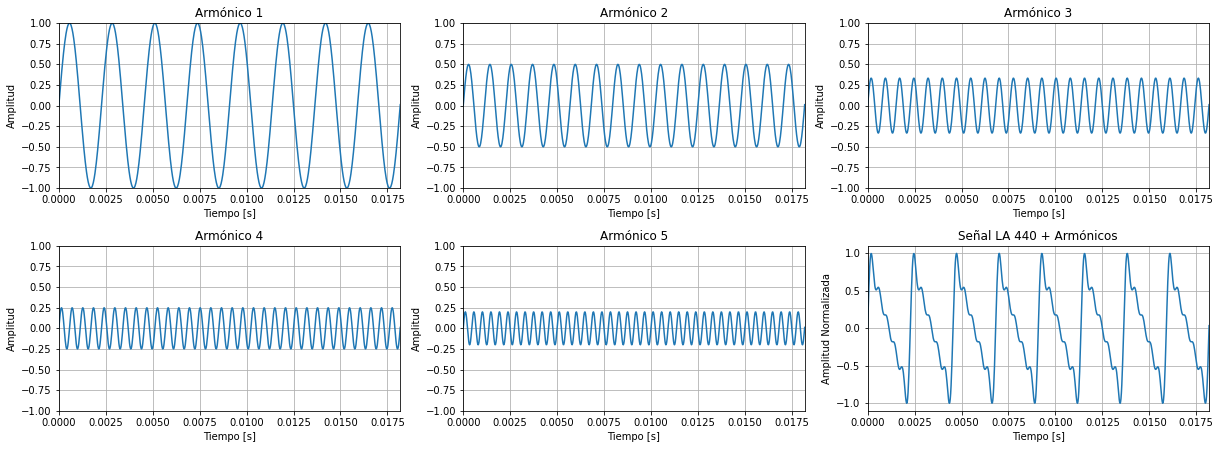

In [77]:
plt.figure(1,figsize=(17,9))
for k in range(1,K+1):
    armonicos = (1/k) * np.sin(2*n*k*np.pi*(f0/fs))
    A += armonicos
    plt.subplot(3,3,k)
    plt.plot(t,armonicos)
    plt.grid()
    plt.xlim(0,(8/f0))
    plt.ylim(-1,1)
    plt.title('Armónico %i' %k)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")   

Amax = np.amax(A)
A = A * (1/Amax)

plt.subplot(3,3,6)
plt.plot(t,A)
plt.grid()
plt.xlim(0,(8/f0))
plt.title('Señal LA 440 + Armónicos')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud Normalizada")

plt.tight_layout()
plt.show()

Se puede ver que la señal resultante se aproxima a una diente de sierra.

### Ejercicio 2

Se importan las bibliotecas necesarias

In [78]:
import random
import plotly.graph_objects as go

Se definen los parámetros a utilizar

In [79]:
mu = 0
sigma = 1

Se define la funcion para calcular el valor medio de los elementos en un vector

In [80]:
def valor_medio(valores):
    sumatoria = 0
    for i in valores:
        sumatoria += i
    return sumatoria / len(valores)

Se define una funcion para calcular el desvío estandar de los valores de los elementos en un vector

In [81]:
def desvio_estandar(medio, valores):
    sumatoria = 0
    for i in valores:
        sumatoria += (i - medio)**2
    ds = (sumatoria/(len(valores)-1))**0.5
    error = 100-ds*100/1
    return ds, error

Se inicializan arrays para guardar los datos

In [82]:
arrayTabla = [5, 10, 100, 1000, 10000, 100000]
averageArray = []
dsArray = []
errorArray = []

Se itera para dar valores a los arrays creados


In [83]:
for i in arrayTabla:
    L = i
    signal = []
    for i in range(L):
        temp = random.gauss(mu, sigma)
        signal.append(temp)
    average = valor_medio(signal)
    averageArray.append(average)
    ds, error = desvio_estandar(average, signal)
    dsArray.append(ds)
    errorArray.append(np.abs(error))



Gráfico en tabla

In [84]:
DC_SNR_layout = go.Layout(
    title='Desviación Estándar y Error según longitud de señal',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig2 = go.Figure(data=[go.Table(header=dict(values=['L [muestras]', ' Desv. Estándar', 'Error [%]'],align='center'),
                cells=dict(values=[np.array(arrayTabla).astype(str), np.around(dsArray, 2), np.around(errorArray,2)],align='center'))
                ],
                layout=DC_SNR_layout)
fig2.show()

Se puede ver que a medida que la señal aleatoria aumenta su dimensión, el desvío estandar tiende a 1, con un error cada vez menor, aproximandose al caso ideal de distribucion normal

## Ejercicio 3

Defino el desvio estandar de las 3 señales con ruido


In [85]:
sigma1 = 1
sigma2 = 0.1
sigma3 = 3



Defino señales de ruido con desvio estandar 0.1, 1 y 3


In [86]:
x1 = np.random.normal(0, sigma1, len(t))
x2 = np.random.normal(0, sigma2, len(t))
x3 = np.random.normal(0, sigma3, len(t))



Defino 3 señales con cada ruido respectivamente combinado a la señal del ejercicio 1


In [87]:
AX1 = A + x1
AX2 = A + x2
AX3 =  A + x3



Normalizo las 3 señales nuevas


In [88]:
AX1max = np.amax(AX1)
AX1 = AX1 * (1/AX1max)
AX2max = np.amax(AX2)
AX2 = AX2 * (1/AX2max)
AX3max = np.amax(AX3)
AX3 = AX3 * (1/AX3max)



Grafico las 3 señales normalizadas


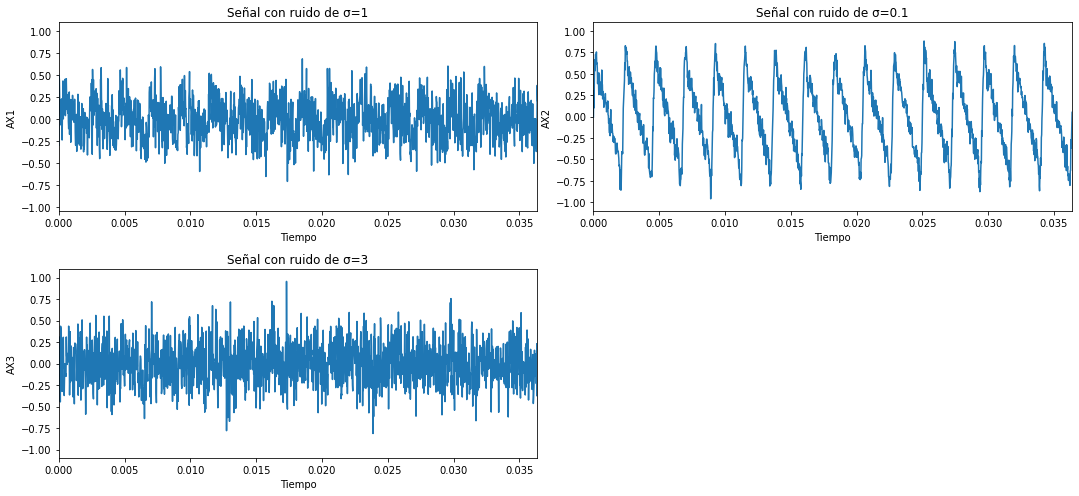

In [89]:
plt.figure(3, figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, AX1)
plt.title('Señal con ruido de σ=1')
plt.xlabel("Tiempo")
plt.ylabel("AX1")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, AX2)
plt.title('Señal con ruido de σ=0.1')
plt.xlabel("Tiempo")
plt.ylabel("AX2")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, AX3)
plt.title('Señal con ruido de σ=3')
plt.xlabel("Tiempo")
plt.ylabel("AX3")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Defino formula que calcula relacion señal ruido


In [90]:
def Señal_Ruido(A,sigma,f_A):
    SNR = np.round((np.amax(A)-np.mean(A))/sigma,2)
    return SNR

SNR1 = Señal_Ruido(AX1,sigma1,fs/f0)
SNR2 = Señal_Ruido(AX2,sigma2,fs/f0)
SNR3 = Señal_Ruido(AX3,sigma3,fs/f0)



Agregandole a cada señal un componente de continua con los valores -10, 10 y 1000

In [91]:
DCcomps = [-10, 10, 1000]

AX1_C1 = AX1 + DCcomps[0]
AX2_C1 = AX2 + DCcomps[0]
AX3_C1 = AX3 + DCcomps[0]

AX1_C2 = AX1 + DCcomps[1]
AX2_C2 = AX2 + DCcomps[1]
AX3_C2 = AX3 + DCcomps[1]

AX1_C3 = AX1 + DCcomps[2]
AX2_C3 = AX2 + DCcomps[2]
AX3_C3 = AX3 + DCcomps[2]

Se calcula SNR a cada señal con componente de continua


In [92]:
SNR4 = Señal_Ruido(AX1_C1,sigma1,fs/f0)
SNR5 = Señal_Ruido(AX2_C1,sigma2,fs/f0)
SNR6 = Señal_Ruido(AX3_C1,sigma3,fs/f0)

SNR7 = Señal_Ruido(AX1_C2,sigma1,fs/f0)
SNR8 = Señal_Ruido(AX2_C2,sigma2,fs/f0)
SNR9 = Señal_Ruido(AX3_C2,sigma3,fs/f0)

SNR10 = Señal_Ruido(AX1_C3,sigma1,fs/f0)
SNR11 = Señal_Ruido(AX2_C3,sigma2,fs/f0)
SNR12 = Señal_Ruido(AX3_C3,sigma3,fs/f0)

DC_SNR_layout = go.Layout(
    title='Relaciones Señal-Ruido para distintas desviaciones estándar',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig4 = go.Figure(data=[go.Table(header=dict(values=['Señal con ruido', 'Sigma', 'SNR', 'SNR con DC=-10', 'SNR con DC=10', 'SNR con DC=1000'],align='center'),
                cells=dict(values=[["Señal 1", "Señal 2", "Señal 3"], [sigma1, sigma2, sigma3] , [SNR1, SNR2, SNR3], [SNR4, SNR5, SNR6], [SNR7, SNR8, SNR9], [SNR10, SNR11, SNR12]],align='center'))
                ],
                layout=DC_SNR_layout)
fig4.show()



A medida que el desvio estandar es menor, la relacion señal ruido aumenta, lo cual es coherente con la formula planteada.

El SNR no se modifica con la adición de una componente de continua.

## Ejercicio 4

Se define la función para calcular el promedio en ensamble.



In [93]:
def promedio_ensamble(N):
    # Inicializo Array
    randNoiseSignals = []    

    # Creo las señales y las guardo en el array
    for i in range(N):
        A_randNoise = A + np.random.normal(0, 3, len(t))
        randNoiseSignals.append(A_randNoise)

    # Inicializo un nuevo array que será el promedio, y transpongo el array de señales con ruido para poder sumar los valores para el promedio
    averageA_RN = []
    randNoiseSignals_T = np.array(randNoiseSignals).transpose()
    for i in range(len(randNoiseSignals[0])):
        averageA_RN.append((1/10) * np.sum(randNoiseSignals_T[i]))

    # Mido SNR
    SNR_average = Señal_Ruido(averageA_RN,3,fs/f0)

    # Normalizo
    Amax = np.amax(averageA_RN)
    averageA_RN = averageA_RN / Amax

    return randNoiseSignals, averageA_RN, SNR_average



Se utiliza la función para 10, 100 y 1000 señales.



In [94]:
randNoiseSignals10, averageA_RN10, SNR_average10 = promedio_ensamble(10)
randNoiseSignals100, averageA_RN100, SNR_average100 = promedio_ensamble(100)
randNoiseSignals1000, averageA_RN1000, SNR_average1000 = promedio_ensamble(1000)

Se grafica.



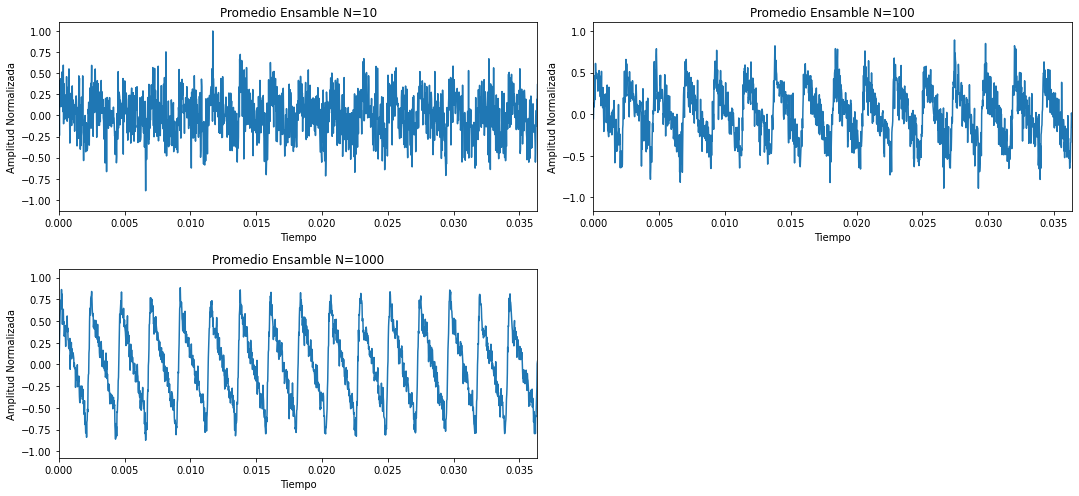

In [95]:
plt.figure(5, figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(t, averageA_RN10)
plt.title('Promedio Ensamble N=10')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,2)
plt.plot(t, averageA_RN100)
plt.title('Promedio Ensamble N=100')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)


plt.subplot(2,2,3)
plt.plot(t, averageA_RN1000)
plt.title('Promedio Ensamble N=1000')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud Normalizada")
plt.xlim(0, 16/f0)
plt.tight_layout()
plt.show()

Se genera tabla de SNRs.

In [96]:
DC_SNR_layout = go.Layout(
    title='SNR para Promedio Ensamble',
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig6 = go.Figure(data=[go.Table(header=dict(values=['Cantidad de señales de ruido', 'SNR promedio', 'SNR ejercicio 3'],align='center'),
                cells=dict(values=[["10", "100", "1000"], [SNR_average10, SNR_average100, SNR_average1000], [SNR1, SNR2, SNR3]],align='center'))
                ],
                layout=DC_SNR_layout)
fig6.show()

Se observa que para mayor cantidad de señales, mayor será el SNR del promedio.

## Ejercicio 5 

Se importan las librerías necesarias.

In [97]:
import time

Se definen las funciones para implementar el filtro de manera directa, o con la implementación recursiva explicada en las bibliografía de referencia.

In [98]:
# Directa
def mediaMovilD(x, M):
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    y = np.zeros(len(x))
    for i in range(M//2, len(x) - M//2):
        y[i] = 0.0
        for j in range(-M//2, M//2 + 1):
            y[i] += x[i+j]
        y[i] = y[i] / M
    return y

# Recursiva
def mediamovildr(x,M):
    if len(x)<M:
        raise Exception('La ventana no debe tener más muestras que la señal a filtrar')
    if len(x)>M:
        y = np.zeros(len(x))
        acc=0.0
        for i in range(0,M):
            acc += x[i]
        y[M//2] = acc/M
        for i in range((M//2)+1,(len(y)-(M//2))):
            acc = acc + x[i+((M-1)//2)]-x[i-(((M-1)//2)+1)]
            y[i] = acc/M
        return y
    else:
        s=len(x)-M
        return np.hstack([np.zeros(M-1),np.mean(x[s:s+M-1])])

### Definición de ventana
Se genera una función para calcular la reducción de un filtro de media móvil de ventana M para una frecuencia dada.

In [99]:
def response_MA_f (x ,M, f, fs=44100, pref=0.00002):

    # Creo sinusoide de frecuencia buscada y aplico filtro MA de ancho M
    sig = np.sin(2*np.arange(len(x))*np.pi*(f/fs))

    MA = mediamovildr(sig, M)

    # Respuesta para la frecuencia buscada
    res = np.amax(MA)/np.amax(sig)

    return res

Se busca mediante iteración y comparación un número de muestras de la ventana que permita una atenuación de al menos el 90% en 880 Hz y frecuencias superiores. En principio se define una función para recorrer los posibles valores de M.

In [100]:
def M_for_response(x,f,response,fs=44100, pref=0.00002):
    for i in range(1,fs//2):
        res = np.zeros(len(f))
        flag = 0
        for j in range(len(f)):    
            res[j] = response_MA_f(x,i,f[j])
            if res[j] < response:
                flag += 1
        if flag == len(f):
            M_for_R = i
            break
    return M_for_R

Como las señales tienen la misma longitud, basta con desarrollar sólo para una de ellas.

In [101]:
M_minus90_AX1 = M_for_response(AX1,[880, 1320, 1760, 2200], 0.1)

print("Largo de Ventana MA para atenuar 90%:", M_minus90_AX1)

Largo de Ventana MA para atenuar 90%: 91


Se chequea que se cumpla la atenuación para todos los armónicos

In [102]:
att_MA_440 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440)),2)
att_MA_880 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*2)),2)
att_MA_1320 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*3)),2)
att_MA_1760 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*4)),2)
att_MA_2200 = np.round(100*(1-response_MA_f(AX1,M_minus90_AX1,440*5)),2)

DC_SNR_layout = go.Layout(
    title='Atenuación por MA de M=%i según frecuencia' %M_minus90_AX1,
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig7 = go.Figure(data=[go.Table(header=dict(values=['Frecuencia', 'Atenuación [%]'],align='center'),
                cells=dict(values=[['440 Hz:','880 Hz:','1320 Hz:','1760 Hz:','2200 Hz:'], [att_MA_440, att_MA_880, att_MA_1320, att_MA_1760, att_MA_2200]],align='center'))
                ],
                layout=DC_SNR_layout)
fig7.show()

Son todos menores a 0.1, pero 440 Hz también se encuentra atenuado en casi un 90%, por lo cual no sería la condición buscada.

Se busca entonces filtrar las frecuencias mayores a 880 Hz en un 90% en promedio.

In [103]:
def M_for_response_f(x,f,response,fs=44100, pref=0.00002):
    for i in range(1,fs//2):
        res = np.zeros(len(f))
        for j in range(len(f)):    
            res[j] = response_MA_f(x,i,f[j])
        if np.average(res) < response:
            M_for_R = i
            break
    return M_for_R

M_minus90_avg = M_for_response_f(AX1,[880, 1320, 1760, 2200], 0.1)

print("Largo de Ventana MA para atenuar 90% en promedio:", M_minus90_avg)

Largo de Ventana MA para atenuar 90% en promedio: 49


Se chequea que se cumpla la atenuación para todos los armónicos

In [104]:
att_MA_avg_440 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440)),2)
att_MA_avg_880 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*2)),2)
att_MA_avg_1320 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*3)),2)
att_MA_avg_1760 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*4)),2)
att_MA_avg_2200 = np.round(100*(1-response_MA_f(AX1,M_minus90_avg,440*5)),2)

DC_SNR_layout = go.Layout(
    title='Atenuación por MA de M=%i según frecuencia' %M_minus90_avg,
    title_x=0.5,
    margin=go.layout.Margin(
        autoexpand=True
    )
)

fig8 = go.Figure(data=[go.Table(header=dict(values=['Frecuencia', 'Atenuación [%]'],align='center'),
                cells=dict(values=[['440 Hz:','880 Hz:','1320 Hz:','1760 Hz:','2200 Hz:'], [att_MA_avg_440, att_MA_avg_880, att_MA_avg_1320, att_MA_avg_1760, att_MA_avg_2200]],align='center'))
                ],
                layout=DC_SNR_layout)
fig8.show()

En este caso se logra filtrar los armónicos mayores manteniendo un 65% de la frecuencia fundamental, por lo cual resulta apropiado como largo de la ventana para el filtro.

El valor de 49 muestras resulta lógico, ya que es cercano al número de muestras por cada período de la frecuencia de 880 Hz (44100/440 = 50 muestras aprox.), lo cual significa que cada ciclo de esa frecuencia está siendo prácticamente eliminado al promediarse. Los otros armónicos tienen períodos de 33, 25 y 20 muestras, lo cual implica que el de 25, al entrar 2 veces en 50, tendrá una atenuación similar al de 50 muestras, mientras que los otros dos no tendrán tanta atenuación, lo cual se observa en los resultados anteriores.

### Implementación de filtros con ventana elegida y medición del tiempo de ejecución

Implementación directa

El tiempo que tarda el filtro directo en ejecutarse es de 1.8 segundos


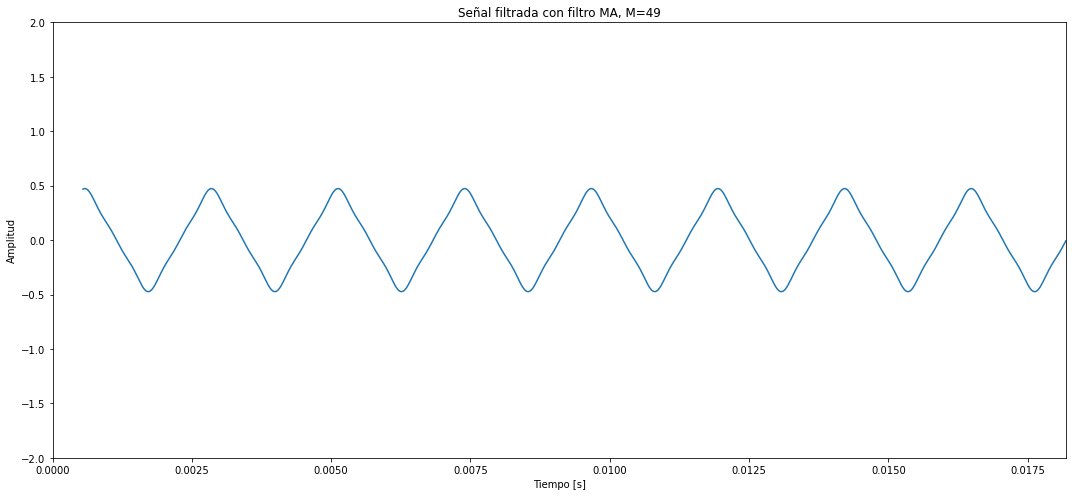

In [119]:
inicio = time.time()
filtranding = mediaMovilD(A, M_minus90_avg)
final = time.time()
tiempo = final-inicio
print("El tiempo que tarda el filtro directo en ejecutarse es de " +str(round(tiempo,2))+ " segundos")

plt.figure(9, figsize=(15,7))
plt.plot(t[M_minus90_avg//2:], filtranding[M_minus90_avg//2:])
plt.title('Señal filtrada con filtro MA, M=49')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, 8/f0)
plt.ylim(-2,2)

plt.tight_layout()
plt.show()

Implementación recursiva

El tiempo que tarda el filtro de implementación recursiva en ejecutarse es de 0.08 segundos


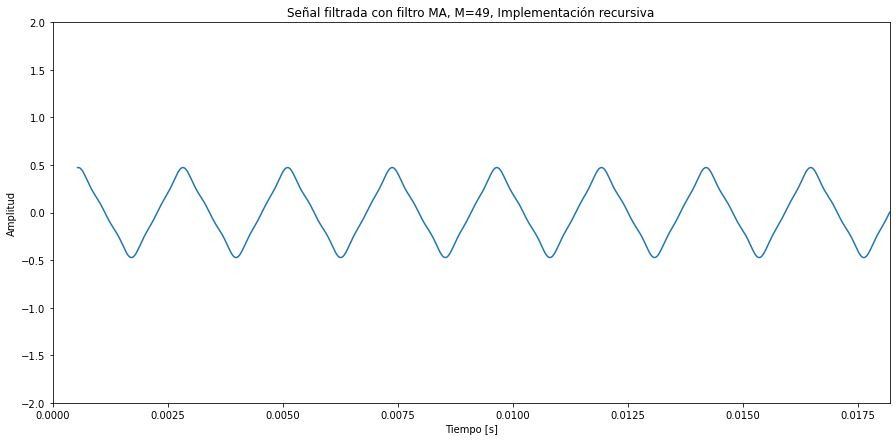

In [120]:
inicio = time.time()
xfr = mediamovildr(A,M_minus90_avg)
final = time.time()
tiempo = final-inicio
print("El tiempo que tarda el filtro de implementación recursiva en ejecutarse es de " +str(round(tiempo,2))+ " segundos")

plt.figure(10, figsize=(15,7))
plt.plot(t[M_minus90_avg//2:], xfr[M_minus90_avg//2:])
plt.title('Señal filtrada con filtro MA, M=49, Implementación recursiva')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, 8/f0)
plt.ylim(-2,2)

plt.show()

Se puede concluir que la implementacion recursiva realiza los calculos en un tiempo mucho menor que la de implementacion directa.

## Ejercicio 6

Se utiliza la ventana obtenida en el ejercicio 5.

In [108]:
M = 50

Genero la respuesta al impulso y la convoluciono con la señal. Grafico la señal filtrada del ejercicio 5 junto con el resultado de la convolución.

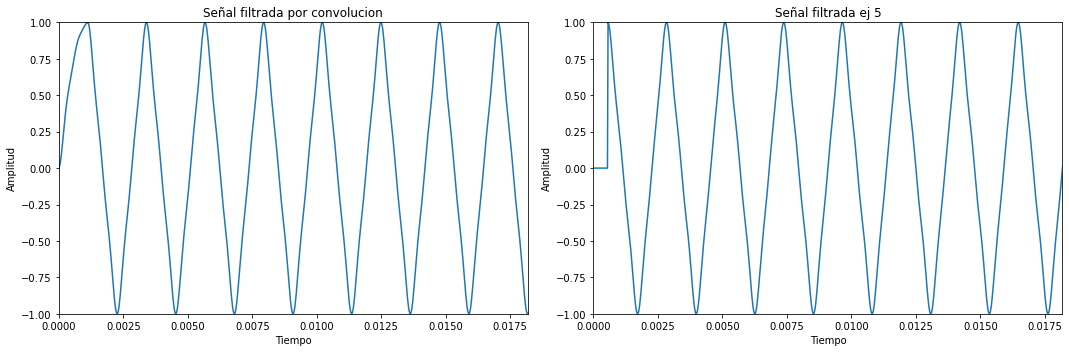

In [117]:
w = 1/M * np.append(np.ones(M), np.zeros(len(t)-M))
#Hago la convolucion entre la ventana y la señal
h = sig.convolve(A, w, mode='full')
h = h / np.amax(h)
   
plt.figure(11, figsize=(15,5))

#Grafico la convolucion entre w y la señal del ejercicio 1
plt.subplot(1,2,1)
plt.plot(t, h[0:len(t)])
plt.xlim(0, 8/f0)
plt.ylim(-1,1)
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.title("Señal filtrada por convolucion")

plt.subplot(1,2,2)
# Usando implementación recursiva
filtranding = mediamovildr(A, M)
# Normalizo
filtranding = filtranding / np.amax(filtranding)
plt.plot(t, filtranding)
plt.xlim(0, 8/f0)
plt.ylim(-1,1)
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.title("Señal filtrada ej 5")

plt.tight_layout()
plt.show()

Se llega al mismo resultado tanto haciendo la convolucion como utilizando una de las funciones del ejercicio 5. Sólo se observa una diferencia en el comienzo de la señal, relacionado a cómo el algoritmo sig. convolve maneja las muestras iniciales.

## Ejercicio 7

Defino M y genero ventana de Blackman

In [112]:
M = 50

a0 = 0.42
a1 = 0.5
a2 = 0.08
blackMan = np.zeros(M)
for i in range(M):
    blackMan[i] = a0 - a1 * np.cos((2*np.pi*i)/(M-1)) + a2 * np.cos((4*np.pi*i)/(M-1)) 

Convoluciono el filtro de  Blackman con la señal del ejercicio 1

In [113]:
convBlack = np.convolve(A, blackMan, mode='full')
# Normalizo
convBlack = convBlack / np.amax(convBlack)

Defino muestras iniciales y finales para graficar la señal filtrada quitando las muestras agregadas por la convolución en los extremos. Grafico resultado.

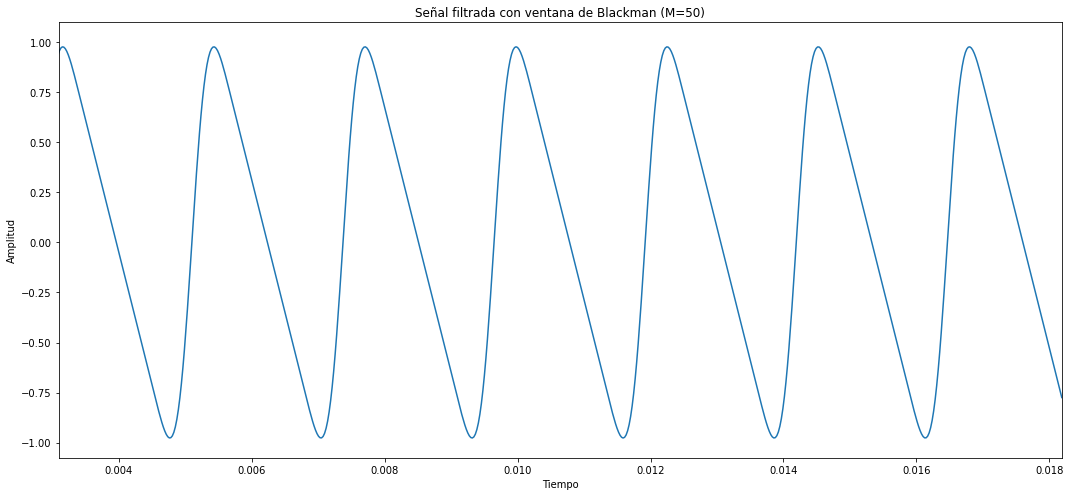

In [121]:
convBlackStart = ( (len(convBlack)-len(t)) // 2 )
convBlackEnd = ( (len(convBlack)+len(t)) // 2 )

plt.figure(12, figsize=(15,7))
plt.plot(t, convBlack[0:len(t)])
plt.xlim(0.0031, 8/f0)
plt.title('Señal filtrada con ventana de Blackman (M=50)')
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()


Se puede apreciar que el filtraje con la ventana Blackman es mucho mejor que el realizado en los ejercicios 5 y 6, dando una senoidal más aproximada al primer armonico de la señal original.

## Ejercicio 8

## Ejercicio 9

## Ejercicio 10

## Ejercicio 11

## Ejercicio 12

## Ejercicio 13